In [139]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import numpy as np
import pandas as pd
import cv2
import torchsummary
from sklearn.metrics import recall_score
from glob import glob
import os


import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings(action='ignore')
from os.path import isfile, join, abspath, exists, isdir, expanduser
from torchvision import transforms, datasets, models
from PIL import Image


In [140]:
GPU_NUM = 2 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')


Current cuda device  2
TITAN Xp
Memory Usage:
Allocated: 0.1 GB
Cached:    0.5 GB


## Cross Validation

In [142]:
img_dir = '../../../datasets/estern_wells'
#img_dir = '../datasets/test'

result = []
idx = 0

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]
num_to_class = dict(zip(range(len(label_list)), label_list))

for label in num_to_class:
    file_list = glob(os.path.join(img_dir,num_to_class[label],'*'))
    
    for file in file_list:
#         result.append(['Train_{}'.format(idx), idx, label, num_to_class[label], file])
        result.append([idx, label, num_to_class[label], file])
        idx += 1

df_train = pd.DataFrame(result, columns=['idx','num_label','cate_label','image'])
df_train

,idx,num_label,cate_label,image
0,0,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...
1,1,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...
2,2,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...
3,3,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...
4,4,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...
...,...,...,...,...
14069,14069,27,baeksansu_500_pet,../../../datasets/estern_wells/baeksansu_500_p...
14070,14070,27,baeksansu_500_pet,../../../datasets/estern_wells/baeksansu_500_p...
14071,14071,27,baeksansu_500_pet,../../../datasets/estern_wells/baeksansu_500_p...
14072,14072,27,baeksansu_500_pet,../../../datasets/estern_wells/baeksansu_500_p...


In [144]:
data_dir = '../../../datasets/estern_wells'
#img_dir = '../datasets/estern_wells'
cache_dir = expanduser(join('~', '.torch'))

IMG_SIZE = 224
BATCH_SIZE = 32

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]
classes = os.listdir(data_dir)
#classes = sorted(classes, key=lambda item: (int(item.partition(' ')[0])
                               #if item[0].isdigit() else float('inf'), item))
num_to_class = dict(zip(range(len(classes)), classes))
num_to_class

{0: 'toreta_355_can',
 1: 'starbucks_pike_275_pet',
 2: 'cider_330_can',
 3: 'coca_350_can',
 4: 'starbucks_cream_275_pet',
 5: 'sky_500_pet',
 6: 'cantata_latte_275_pet',
 7: 'hot6_theking_storm_330_can',
 8: 'burdock_tea_500_pet',
 9: 'colombiana_master_black_500_pet',
 10: 'lipton_355_can',
 11: 'tropicana_apple_355_can',
 12: 'cantata_americano_275_pet',
 13: 'virak_500_pet',
 14: 'aloe_500_pet',
 15: 'trevi_lemon_355_can',
 16: 'power_355_can',
 17: 'welchs_grape_355_can',
 18: 'milkis_320_can',
 19: 'colombiana_master_latte_500_pet',
 20: 'miero_fiber_350_pet',
 21: 'confidence_230_pet',
 22: 'hutgaecha_500_pet',
 23: 'watermelon_500_pet',
 24: 'delmonte_tomato_400_pet',
 25: 'pocari_340_can',
 26: 'lotte_cornslik_tea_500_pet',
 27: 'baeksansu_500_pet'}

In [145]:
# data - id
X = df_train[['idx','num_label']].values[:,0]

# data - value
y = df_train[['idx','num_label']].values[:,1:]

df_train['fold'] = -1

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

for i, (trn_idx, vld_idx) in enumerate(skf.split(X,y)):
    df_train.loc[vld_idx, 'fold'] = i

In [146]:
val_set = 5

trn_fold = [i for i in range(10) if i not in [val_set]]
vld_fold = [val_set]

trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

In [147]:
df_train.head()

,idx,num_label,cate_label,image,fold
0,0,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...,8
1,1,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...,2
2,2,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...,9
3,3,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...,7
4,4,0,toreta_355_can,../../../datasets/estern_wells/toreta_355_can/...,0


## Create Datasets

In [148]:
class CreateDataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img = cv2.imread(self.csv['image'][index]).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_height, self.img_width))
        
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        label = self.csv.iloc[index].num_label
        
        return (img, label)

In [315]:
# val_set = 5

# trn_fold = [i for i in range(10) if i not in [val_set]]
# vld_fold = [val_set]

# trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
# vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

In [149]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomGamma, VerticalFlip,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, 
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomContrast, RandomBrightness, RandomCrop, Resize, OpticalDistortion, Normalize
)

from albumentations.pytorch import ToTensor
train_transforms = Compose([
        #Rotate(limit=30, p=0.5),
        #Rotate(limit=180, p=0.5),
        #RandomRotate90(p=1.0)
        #Transpose(p=1.0)
        Resize(248,248, p=0.5),     # resize 후 크롭
        RandomCrop(IMG_SIZE,IMG_SIZE, p=0.5),  # 위에꺼랑 세트
        
        OneOf([
        RandomContrast(p=1, limit=(-0.5,2)),   # -0.5 ~ 2 까지가 현장과 가장 비슷함  -- RandomBrightnessContrast
        RandomBrightness(p=1, limit=(-0.2,0.4)),
        RandomGamma(p=1, gamma_limit=(80,200)),
        ], p=0.6),
            
        OneOf([
            Rotate(limit=30, p=0.5),
            RandomRotate90(p=0.5),
            VerticalFlip(p=0.5)
        ], p=0.3),
    
        MotionBlur(p=0.2),   # 움직일때 흔들리는 것 같은 이미지
        ShiftScaleRotate(shift_limit=0.001, scale_limit=0.1, rotate_limit=30, p=0.3, border_mode=1),
        Resize(IMG_SIZE,IMG_SIZE, p=1),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], p=1),
        ToTensor()
        ],
        p=0.4)

valid_transforms = Compose([Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],p=1),
                            ToTensor(),])

In [150]:
img1 = valid_transforms(image=img)['image']
f, ax = plt.subplots(1,2,figsize=(10,16))
ax[0].imshow(img)
ax[1].imshow(img1.permute(1,2,0))

ax[0].set_title('initial - {}'.format(img.shape))
ax[1].set_title('transformed - {}'.format(img1.shape))

NameError: name 'img' is not defined

In [151]:

train_set = CreateDataset(df_train.loc[trn_idx], IMG_SIZE,IMG_SIZE, transform = train_transforms)
valid_set = CreateDataset(df_train.loc[vld_idx], IMG_SIZE,IMG_SIZE, transform = valid_transforms)


train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

dataset_sizes = {
    'train': len(train_loader.dataset), 
    'valid': len(valid_loader.dataset)
}

---

## Model

### Resnet

In [319]:
import pretrainedmodels

model_name = 'resnet50'
backbone = pretrainedmodels.__dict__[model_name](pretrained='imagenet')
in_features = backbone.last_linear.in_features
backbone.last_linear = nn.Linear(in_features, len(label_list))

### efficientnet

In [46]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b4'

#backbone = EfficientNet.from_pretrained(model_name, num_classes = len(label_list))
#backbone = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
backbone = EfficientNet.from_pretrained(model_name, num_classes = 10)

Loaded pretrained weights for efficientnet-b4


In [47]:
backbone

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [563]:
model = backbone.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='max',
                                                     verbose=True,
                                                     patience=5,
                                                     factor=0.5)

In [564]:
best_score = -1
EPOCH = 100
#model = torch.nn.DataParallel(model, device_ids=[1,2]).cuda()

for epoch in range(EPOCH):
    train_loss = []
    model.train()
    
    for inputs, targets in tqdm_notebook(train_loader):
        
        inputs = inputs.cuda()
        targets = targets.cuda()
        
        result = model(inputs)
        
        loss = loss_fn(result, targets)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())
        
    val_loss = []
    val_true = []
    val_pred = []
    
    model.eval()
    
    with torch.no_grad():
        
        for vld_inputs, vld_targets in tqdm_notebook(valid_loader):
            
            vld_inputs = vld_inputs.cuda()
            vld_targets = vld_targets.cuda()
            
            result = model(vld_inputs)
            
            val_loss.append(loss.item())
            
            result = result.cpu().argmax(dim=1).data.numpy()
            
            val_true.append(vld_targets.cpu().numpy())
            #val_pred.append(np.stack([result], axis=1))
            val_pred.append(result)
            
    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)
    
    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)
    
    score = recall_score(val_true, val_pred, average='macro')
    

    print(f'EPOCH:{epoch}, train_loss: {train_loss:.5f}, val_loss:{val_loss:.5f}, recall:{score:.5f}')
    print('-'* 40)
    
    if score > best_score:
        best_score = score

        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, 'model_feature_b4.pt')
        torch.save(model,'model_total_b4.pt')
        print('model saved!!!')


EPOCH:0, train_loss: 0.85534, val_loss:0.03138, recall:1.00000
----------------------------------------
model saved!!!



EPOCH:1, train_loss: 0.04535, val_loss:0.04899, recall:1.00000
----------------------------------------



EPOCH:2, train_loss: 0.02339, val_loss:0.00531, recall:1.00000
----------------------------------------



EPOCH:3, train_loss: 0.01548, val_loss:0.01994, recall:1.00000
----------------------------------------



EPOCH:4, train_loss: 0.01570, val_loss:0.00256, recall:1.00000
----------------------------------------



EPOCH:5, train_loss: 0.00969, val_loss:0.00079, recall:1.00000
----------------------------------------



EPOCH:6, train_loss: 0.00828, val_loss:0.00111, recall:1.00000
----------------------------------------



EPOCH:7, train_loss: 0.00623, val_loss:0.00046, recall:1.00000
----------------------------------------



EPOCH:8, train_loss: 0.00474, val_loss:0.00067, recall:1.00000
----------------------------------------



EPOCH:9, train_loss: 0.00817, val_loss:0.00107, recall:1.00000
----------------------------------------



EPOCH:10, train_loss: 0.00974, val_loss:0.00288, recall:1.00000
----------------------------------------



EPOCH:11, train_loss: 0.00711, val_loss:0.01361, recall:1.00000
----------------------------------------



EPOCH:12, train_loss: 0.00582, val_loss:0.00538, recall:1.00000
----------------------------------------



EPOCH:13, train_loss: 0.00649, val_loss:0.00061, recall:1.00000
----------------------------------------



EPOCH:14, train_loss: 0.00410, val_loss:0.00026, recall:1.00000
----------------------------------------



EPOCH:15, train_loss: 0.00559, val_loss:0.00049, recall:1.00000
----------------------------------------



EPOCH:16, train_loss: 0.00379, val_loss:0.00507, recall:1.00000
----------------------------------------



EPOCH:17, train_loss: 0.00459, val_loss:0.00196, recall:1.00000
----------------------------------------



EPOCH:18, train_loss: 0.00546, val_loss:0.00016, recall:1.00000
----------------------------------------



EPOCH:19, train_loss: 0.00609, val_loss:0.00227, recall:1.00000
----------------------------------------



EPOCH:20, train_loss: 0.00483, val_loss:0.00059, recall:1.00000
----------------------------------------



EPOCH:21, train_loss: 0.00513, val_loss:0.00009, recall:1.00000
----------------------------------------



EPOCH:22, train_loss: 0.00164, val_loss:0.00140, recall:1.00000
----------------------------------------



EPOCH:23, train_loss: 0.00495, val_loss:0.00205, recall:1.00000
----------------------------------------



EPOCH:24, train_loss: 0.00186, val_loss:0.00006, recall:1.00000
----------------------------------------



EPOCH:25, train_loss: 0.00452, val_loss:0.00014, recall:1.00000
----------------------------------------



EPOCH:26, train_loss: 0.00538, val_loss:0.00026, recall:1.00000
----------------------------------------



EPOCH:27, train_loss: 0.00298, val_loss:0.00015, recall:1.00000
----------------------------------------



EPOCH:28, train_loss: 0.00398, val_loss:0.00018, recall:1.00000
----------------------------------------



EPOCH:29, train_loss: 0.00193, val_loss:0.00021, recall:1.00000
----------------------------------------



EPOCH:30, train_loss: 0.00275, val_loss:0.00027, recall:1.00000
----------------------------------------



EPOCH:31, train_loss: 0.00182, val_loss:0.00005, recall:1.00000
----------------------------------------



EPOCH:32, train_loss: 0.00448, val_loss:0.00049, recall:1.00000
----------------------------------------



EPOCH:33, train_loss: 0.00246, val_loss:0.01201, recall:1.00000
----------------------------------------



EPOCH:34, train_loss: 0.00205, val_loss:0.00026, recall:1.00000
----------------------------------------



EPOCH:35, train_loss: 0.00143, val_loss:0.00004, recall:1.00000
----------------------------------------



EPOCH:36, train_loss: 0.00757, val_loss:0.00098, recall:1.00000
----------------------------------------



EPOCH:37, train_loss: 0.00151, val_loss:0.00008, recall:1.00000
----------------------------------------



EPOCH:38, train_loss: 0.00267, val_loss:0.00007, recall:1.00000
----------------------------------------



EPOCH:39, train_loss: 0.00167, val_loss:0.00007, recall:1.00000
----------------------------------------



EPOCH:40, train_loss: 0.00168, val_loss:0.00090, recall:1.00000
----------------------------------------



EPOCH:41, train_loss: 0.00274, val_loss:0.00037, recall:1.00000
----------------------------------------



EPOCH:42, train_loss: 0.00430, val_loss:0.00010, recall:1.00000
----------------------------------------



EPOCH:43, train_loss: 0.00224, val_loss:0.00011, recall:1.00000
----------------------------------------



EPOCH:44, train_loss: 0.00124, val_loss:0.01069, recall:1.00000
----------------------------------------



EPOCH:45, train_loss: 0.00258, val_loss:0.00083, recall:1.00000
----------------------------------------



EPOCH:46, train_loss: 0.00277, val_loss:0.00132, recall:1.00000
----------------------------------------



EPOCH:47, train_loss: 0.00365, val_loss:0.00006, recall:1.00000
----------------------------------------



EPOCH:48, train_loss: 0.00297, val_loss:0.00365, recall:1.00000
----------------------------------------



EPOCH:49, train_loss: 0.00123, val_loss:0.00003, recall:1.00000
----------------------------------------



EPOCH:50, train_loss: 0.00327, val_loss:0.00004, recall:1.00000
----------------------------------------



EPOCH:51, train_loss: 0.00311, val_loss:0.00013, recall:1.00000
----------------------------------------



EPOCH:52, train_loss: 0.00333, val_loss:0.00003, recall:1.00000
----------------------------------------



EPOCH:53, train_loss: 0.00153, val_loss:0.00002, recall:1.00000
----------------------------------------



EPOCH:54, train_loss: 0.00275, val_loss:0.00010, recall:1.00000
----------------------------------------



EPOCH:55, train_loss: 0.00079, val_loss:0.00089, recall:1.00000
----------------------------------------



EPOCH:56, train_loss: 0.00081, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:57, train_loss: 0.00165, val_loss:0.00021, recall:1.00000
----------------------------------------



EPOCH:58, train_loss: 0.00401, val_loss:0.00031, recall:1.00000
----------------------------------------



EPOCH:59, train_loss: 0.00227, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:60, train_loss: 0.00262, val_loss:0.00003, recall:1.00000
----------------------------------------



EPOCH:61, train_loss: 0.00165, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:62, train_loss: 0.00061, val_loss:0.00079, recall:1.00000
----------------------------------------



EPOCH:63, train_loss: 0.00130, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:64, train_loss: 0.00185, val_loss:0.00008, recall:1.00000
----------------------------------------



EPOCH:65, train_loss: 0.00109, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:66, train_loss: 0.00146, val_loss:0.00264, recall:1.00000
----------------------------------------



EPOCH:67, train_loss: 0.00289, val_loss:0.00007, recall:1.00000
----------------------------------------



EPOCH:68, train_loss: 0.00068, val_loss:0.00003, recall:1.00000
----------------------------------------



EPOCH:69, train_loss: 0.00192, val_loss:0.00008, recall:1.00000
----------------------------------------



EPOCH:70, train_loss: 0.00159, val_loss:0.00006, recall:1.00000
----------------------------------------



EPOCH:71, train_loss: 0.00203, val_loss:0.00002, recall:1.00000
----------------------------------------



EPOCH:72, train_loss: 0.00195, val_loss:0.00002, recall:1.00000
----------------------------------------



EPOCH:73, train_loss: 0.00157, val_loss:0.00026, recall:1.00000
----------------------------------------



EPOCH:74, train_loss: 0.00056, val_loss:0.00014, recall:1.00000
----------------------------------------



EPOCH:75, train_loss: 0.00212, val_loss:0.00003, recall:0.99903
----------------------------------------



EPOCH:76, train_loss: 0.00158, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:77, train_loss: 0.00221, val_loss:0.00002, recall:1.00000
----------------------------------------



EPOCH:78, train_loss: 0.00264, val_loss:0.00005, recall:1.00000
----------------------------------------



EPOCH:79, train_loss: 0.00205, val_loss:0.00010, recall:1.00000
----------------------------------------



EPOCH:80, train_loss: 0.00266, val_loss:0.00012, recall:1.00000
----------------------------------------



EPOCH:81, train_loss: 0.00180, val_loss:0.00003, recall:1.00000
----------------------------------------



EPOCH:82, train_loss: 0.00090, val_loss:0.00003, recall:1.00000
----------------------------------------



EPOCH:83, train_loss: 0.00026, val_loss:0.00030, recall:1.00000
----------------------------------------



EPOCH:84, train_loss: 0.00035, val_loss:0.00000, recall:1.00000
----------------------------------------



EPOCH:85, train_loss: 0.00050, val_loss:0.00000, recall:1.00000
----------------------------------------



EPOCH:86, train_loss: 0.00095, val_loss:0.00005, recall:1.00000
----------------------------------------



EPOCH:87, train_loss: 0.00296, val_loss:0.00002, recall:1.00000
----------------------------------------



EPOCH:88, train_loss: 0.00135, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:89, train_loss: 0.00157, val_loss:0.00105, recall:1.00000
----------------------------------------



EPOCH:90, train_loss: 0.00254, val_loss:0.09545, recall:1.00000
----------------------------------------



EPOCH:91, train_loss: 0.00152, val_loss:0.00003, recall:1.00000
----------------------------------------



EPOCH:92, train_loss: 0.00064, val_loss:0.00002, recall:1.00000
----------------------------------------



EPOCH:93, train_loss: 0.00064, val_loss:0.00000, recall:1.00000
----------------------------------------



EPOCH:94, train_loss: 0.00152, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:95, train_loss: 0.00218, val_loss:0.00088, recall:1.00000
----------------------------------------



EPOCH:96, train_loss: 0.00109, val_loss:0.00001, recall:1.00000
----------------------------------------



EPOCH:97, train_loss: 0.00177, val_loss:0.00002, recall:1.00000
----------------------------------------



EPOCH:98, train_loss: 0.00190, val_loss:0.02307, recall:1.00000
----------------------------------------



EPOCH:99, train_loss: 0.00220, val_loss:0.00006, recall:1.00000
----------------------------------------


---

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

## Inference

In [565]:
model = torch.load('./model_total_b4.pt')
model.cuda()
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [622]:
infer_data = '../../datasets/cls_test/q/0_l_0.jpg'
img = cv2.imread(infer_data).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = valid_transforms(image=img)['image']
img = img.unsqueeze(0)


with torch.no_grad():
    #x = img.to(device)
    x = img.cuda()
    #output = model.cuda()(x.cuda())
    output = model(x)
    _, output_index = torch.max(output, 1)
print(num_to_class[output_index.cpu().numpy()[0]])

#plt.imshow(img.squeeze(0).permute(1,2,0))

colombiana_master_black_500_pet


In [400]:
model = torch.load('./model_total.pt')
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [469]:
with torch.no_grad():
    x = img.to(device)
    output = model.cuda()(x.cuda())
    #model.cuda()(img.cuda())
    #output = model(x)
    _, output_index = torch.max(output, 1)
print(num_to_class[output_index.cpu().numpy()[0]])

tensor([0, 0, 0, 0, 0, 0, 0])

## batch infer

In [627]:
import glob
import natsort

TEST_BATCH_SIZE = 7

class TestDataset(Dataset):
    def __init__(self, img_list, img_height, img_width, transform):
        self.img_list = img_list
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        #img_list = natsort.natsorted(glob.glob('../../datasets/cls_test/q/*.jpg'))
        img = cv2.imread(self.img_list[index]).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_height, self.img_width))
        
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        label = 0
        
        return (img, label)


model = torch.load('./model_total_b4.pt')
model.eval()

img_list = natsort.natsorted(glob.glob('../../datasets/cls_test/q/*.jpg'))
test_dataset = TestDataset(img_list, IMG_SIZE,IMG_SIZE, transform = valid_transforms)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2)                             

with torch.no_grad():
    num = 1
    rst = []
    for tst_inputs, tst_targets in tqdm_notebook(test_loader):
        tst_inputs = tst_inputs.cuda()
        tst_targets = tst_targets.cuda()

        result = model(tst_inputs)

        result = result.cpu().argmax(dim=1).data.numpy()
        rst.append(result)
        #print(num, result)
        num += 1
print([list(map(lambda x : num_to_class[x], i)) for i in rst])


[['colombiana_master_black_500_pet', 'colombiana_master_latte_500_pet', 'cantata_latte_275_pet', 'cantata_americano_275_pet', 'starbucks_cream_275_pet', 'starbucks_pike_275_pet', 'pocari_340_can'], ['baeksansu_500_pet', 'sky_500_pet', 'lotte_cornslik_tea_500_pet', 'miero_fiber_350_pet', 'burdock_tea_500_pet', 'hutgaecha_500_pet', 'virak_500_pet'], ['pocari_340_can', 'power_355_can', 'toreta_355_can', 'confidence_230_pet', 'delmonte_tomato_400_pet', 'aloe_500_pet', 'watermelon_500_pet'], ['coca_350_can', 'cider_330_can', 'milkis_320_can', 'welchs_grape_355_can', 'tropicana_apple_355_can', 'lipton_355_can', 'trevi_lemon_355_can']]


In [6]:
from efficientnet.tfkeras import EfficientNetB4, preprocess_input

base_model = EfficientNetB4(weights='imagenet', 
                            include_top=True,
                            input_shape=(380, 380, 3))

In [7]:
base_model.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [8]:
from efficientnet.tfkeras import EfficientNetB4, preprocess_input
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D


def create_model():
    model = models.Sequential()
    model.add(base_model_f)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(10, activation='softmax'))
    return model

base_model_f = EfficientNetB4(weights='imagenet', 
                            include_top=False,
                            input_shape=(224, 224, 3))
asdd = create_model()
asdd.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 18,136,418
Trainable params: 18,010,706
Non-trainable params: 125,712
______________________________________

In [216]:
from torchsummary import summary

summary(backbone.cuda(), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 226, 226]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

In [289]:
new_backbone = nn.Sequential(*backbone.children())[:-4]
summary(new_backbone, input_size = (3,224,224))
#summary(new_backbone.cuda(), (3, 224,224))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [286]:
rr = nn.Sequential(new_backbone, 
                   nn.AdaptiveAvgPool2d(new_backbone[-1].num_features),
                   nn.Linear(new_backbone[-1].num_features, 256, bias=True),
                  nn.BatchNorm2d(256, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
                  nn.ReLU(),
                  nn.Linear(256, 28))  # num_label

In [288]:
summary(rr.cpu(), input_size=(3,224,224))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [285]:
rst = rr.cpu()(i.cpu())
rst.shape

NotImplementedError: 

In [1]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
backbone = EfficientNet.from_pretrained(model_name, num_classes = 28)


Loaded pretrained weights for efficientnet-b0


In [233]:
new_backbone = nn.Sequential(*backbone_b0.children())[:-4]


In [234]:
new_backbone

Sequential(
  (0): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (2): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1

In [134]:
def swish(x): 
    return x * torch.sigmoid(x)


In [153]:
for i,j in train_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


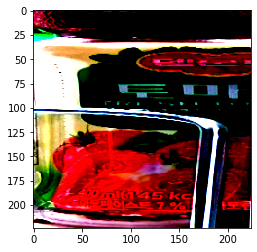

In [159]:
plt.imshow(i[0].permute(1,2,0))

In [164]:
num_to_class[24]

'delmonte_tomato_400_pet'

In [266]:
rst = rr.cpu()(i.cpu())
rst

tensor([[ 0.0334,  0.0011,  0.2481,  0.0982,  0.1662,  0.3204,  0.1241,  0.1778,
         -0.0691, -0.1553],
        [-0.0590,  0.0377,  0.0237,  0.1241, -0.1621,  0.1861, -0.3102,  0.0016,
         -0.1821,  0.1431],
        [-0.4161,  0.0478, -0.1180,  0.1253,  0.0409,  0.3754, -0.0417, -0.3081,
          0.0125,  0.0473],
        [-0.0239,  0.0318, -0.1380, -0.1213,  0.0402, -0.4699, -0.1697, -0.1243,
         -0.1730,  0.2415],
        [ 0.4018,  0.1443,  0.1603, -0.0373, -0.0205, -0.0157,  0.1558,  0.0792,
         -0.1234, -0.0647],
        [-0.0553,  0.1757, -0.0014,  0.0945,  0.0956, -0.0913,  0.0116, -0.1945,
         -0.2778, -0.2369],
        [-0.0354,  0.1999, -0.0374, -0.3136,  0.0854, -0.0640,  0.1631, -0.1789,
         -0.1528,  0.0111],
        [-0.1891, -0.0211, -0.0518, -0.1460,  0.0012, -0.2373,  0.2597, -0.0356,
         -0.1128, -0.0204],
        [-0.2515,  0.1565,  0.0158, -0.1255,  0.3004,  0.1816, -0.0690,  0.1318,
          0.0762,  0.1317],
        [-0.0574,  

In [276]:
rst[5].argmax()

tensor(1)

In [277]:
rst = backbone.cpu()(i.cpu())
rst

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [499]:
import torchvision

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)